In [35]:
import importlib
import esco_utils as eu
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

importlib.reload(eu)

API_TOKEN = eu.get_token()
client = eu.Client(API_TOKEN)

client.api.base_api_url = 'http://flask_sdk:6221'

{'data': {'token': '12a1bad0-4cb1-464c-8c8e-344957672bef'}, 'message': 'successful', 'meta': {}}


In [2]:
vac_conn, skill_conn = eu.load_skillLab_DB()

In [87]:
tags, labels, pred_stats, user_stats = eu.get_stats(client)
pred_stats.to_csv('data/pred_stats.csv')
user_stats.to_csv('data/user_stats.csv')
labels.to_csv('data/labels.csv')
tags.to_csv('data/tags.csv')

/home/esco_utils.py:53: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  for task in tasks.to_dict(orient="record")]


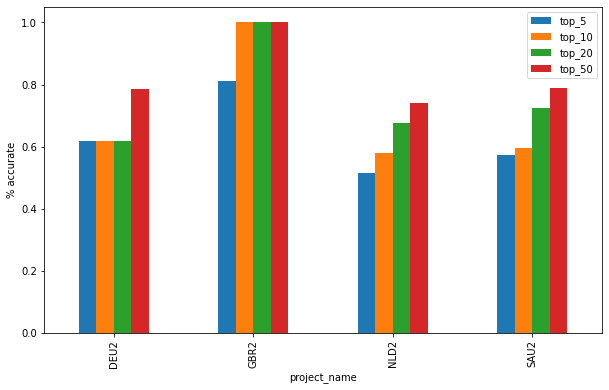

In [88]:
df = tags.groupby('project_name')[['top_5','top_10','top_20','top_50']].mean()
df.plot.bar(figsize=( 10,6))
plt.ylabel('% accurate');

total active time (min) 50.0
number of labels 43
average time (min/label) 1.2


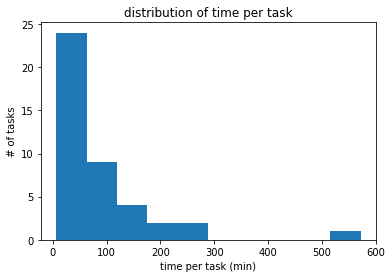

In [89]:
df = labels.loc[labels.email=='yalda2@humansintheloop.org']
response_times = pd.to_datetime(df.inserted_at).diff()
response_times = response_times.apply(lambda x: x.total_seconds())
active_time = np.sum(response_times[response_times<60*5])/60
print(f'total active time (min) {active_time:.1f}')
print(f'number of labels {len(df)}')
print(f'average time (min/label) {active_time/len(df):.1f}')

plt.hist(response_times);
plt.xlabel('time per task (min)')
plt.ylabel('# of tasks')
plt.title('distribution of time per task');

In [100]:
df = tags.loc[tags.email=='yalda2@humansintheloop.org']
sample = df.loc[df.pred_rank>100].iloc[2]
sample_data = task_data.loc[task_data.task_id==sample.task_id].iloc[0]
sample.search_name, sample.occupation_title, sample_data.title, sample_data.description

('ممثل المبيعات التجارية / ممثلة المبيعات التجارية',
 'ممثل المبيعات التجارية / ممثلة المبيعات التجارية',
 'مندوب مبيعات',
 'تنظيم زيارات ميدانية يومياً ومتابعتها مع العملاء .. القيام بعملية عرض المنتجات و الخدمات بصورة مهنية و تسويقية عالية .. العمل مع العملاء بمهنية .. التأكد من التحصيل و التسوية المالية التي تتم وفقاً لشروط الدفع المحددة من الشركة .. الإطلاع على العروض الجديدة و متابعة التحديثات على الخدمة بشكل مستمر .. الإلتزام بتحقيق الهدف البيعي (التارجت) المحدد من قبل الادارة .. العمل على توسيع قاعدة البيانات .. رواتب + بدلات + عمولات مجزيه')

In [92]:
all_projs = client.get_all_projects()['data']['projects']
name2id = {prj['project_name']:prj['project_id'] for prj in all_projs}

statuses = ['in-progress', 'pending', 'completed']
tasks = [{**{'project_name':pname,'project_id':pid},**task} 
         for pname,pid in name2id.items() 
         for status in statuses 
         for task in client.get_all_tasks(pid,status=status)['data']['tasks']]
tasks = pd.DataFrame(tasks).rename(columns={'_id':'task_id'})
tasks['beta'] = tasks.project_name.apply(lambda x: len(x)==4 and x[3]=='2') # designate beta test 
tasks = tasks[tasks.beta]
task_data = [{**task,**client.get_task(task['project_id'],task['task_id'])["data"]["items"][0]["data"]} 
             for task in tasks.to_dict(orient="record")]
task_data = pd.DataFrame(task_data)

/tmp/ipykernel_167/1452598119.py:13: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  for task in tasks.to_dict(orient="record")]


In [116]:
task_data['num_words'] = task_data.description.apply(lambda x:len(x.split()))
task_data.groupby('project_name').median()['num_words']

project_name
BRA2    124.0
DEU2    327.0
GBR2    357.0
MEX2    161.0
NLD2    397.5
SAU2     66.5
Name: num_words, dtype: float64